# Data Preprocessing
### Brendon & Alec Barrios     |     08/08/2020
Using OSIC Pulmonary Fibrosis Progression dataset from Kaggle.com

<https://www.kaggle.com/c/osic-pulmonary-fibrosis-progression/overview>

Adapted from: <https://www.kaggle.com/sentdex/first-pass-through-data-w-3d-convnet>

In [1]:
import os
import glob
import pydicom
import pandas as pd

DATA_DIR = "train/"
patients = os.listdir(DATA_DIR)
train_image_files = sorted(glob.glob(os.path.join(DATA_DIR, '*','*.dcm')))

labels_df = pd.read_csv("train.csv", index_col=0)
# labels_df.head(20)

In [2]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt

IMG_SIZE = 80     # recommended minimum: 70
NUM_SLICES = 30   # recommended minimum: 20
SAVE_FILE = "{}data-{}x{}x{}.npy".format("train", IMG_SIZE, IMG_SIZE, NUM_SLICES)

In [4]:
import scipy.ndimage as ndimage
from skimage import measure, morphology, segmentation
from skimage.measure import label, regionprops
from skimage.segmentation import clear_border
from sklearn.cluster import KMeans

def make_lungmask(img, display=False):
    row_size= img.shape[0]
    col_size = img.shape[1]
    
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    
    # Find the average pixel value near the lungs
    # to renormalize washed out images
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    
    # To improve threshold finding, I'm moving the 
    # underflow and overflow on the pixel spectrum
    img[img==max]=mean
    img[img==min]=mean
    
    # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.

    eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(eroded,np.ones([8,8]))

    labels = measure.label(dilation) # Different labels are displayed in different colors
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
            good_labels.append(prop.label)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0


    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask 
    
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation

    if (display):
        fig, ax = plt.subplots(3, 2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("After Erosion and Dilation")
        ax[1, 0].imshow(dilation, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Labels")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(mask, cmap='gray')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Apply Mask on Original")
        ax[2, 1].imshow(mask*img, cmap='gray')
        ax[2, 1].axis('off')
        
        plt.show()
    return mask*img

In [5]:
def chunks(l, n):
    # Credit: Ned Batchelder
    # Link: http://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

def mean(l):
    return sum(l)/len(l)

def normalize(a):
    norm = np.linalg.norm(a)
    if norm == 0:
        return a
    return a / norm


def process_data(patient, labels_df, img_px_size=70, num_slices=20, visualize=False):
    
    print(patient)
    path = os.path.join(DATA_DIR, patient)
    slices = [pydicom.read_file(os.path.join(path, file)) for file in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2])) # sorts images serially
    
    new_slices = []
    slices = [cv2.resize(each_slice.pixel_array, (img_px_size, img_px_size)) for each_slice in slices]
           
    chunk_step = math.ceil(len(slices) / num_slices) # (num_slices^2 + 1)/num_slices
    
    # Chunks and averages images for patients with > NUM_SLICES images
    for slice_chunk in chunks(slices, chunk_step):
        avg_slice = np.array(list(map(mean, zip(*slice_chunk))))
#         new_slices.append(avg_slice)
        new_slices.append(make_lungmask(avg_slice))  
    """
    probably the best place to apply mask ^^^, but will need to rework which images are allowed in the chunks
    """ 
    
    print("Chunked Slices:", len(new_slices))    
    
    # Handle data with less than num_slices images
    diff = num_slices - len(new_slices)
    if diff:
        for n in range(diff):
            mid = int(len(new_slices) / 2)
            # possibly mirror the duplicate images(?)
            new_slices.append(new_slices[mid])
        
    # Handle data with more than num_slices images
    while len(new_slices) > num_slices:
        new_img = list(map(mean, zip(*[new_slices[-1], new_slices[-2]])))
        del new_slices[num_slices]
        new_slices[num_slices - 1] = new_img
        
    print("  Final Slices:", len(new_slices))
    
    if visualize:
        cols = int(num_slices / 5)
        fig = plt.figure(figsize=(16,12)) # double the default figsize
        for num, each_slice in enumerate(new_slices):
            y = fig.add_subplot(5, cols, num+1)
            y.imshow(each_slice, cmap='gray')
        plt.show
        
    '''
    Obtain slope of FVC Score as label
    Possibly check R^2 values as a counterpart to confidence score
    Check if non-linear functions describe FVC trends better than linear functions
    If so, brainstorm a numeric readout (to replace slope) from the non-linear f(x) that works best
    '''
    FVC = np.array(labels_df.at[patient, "FVC"])
    Weeks = np.array(labels_df.at[patient, "Weeks"])
    m, b = np.polyfit(Weeks, FVC, 1) # y = m*x + b; where x = Weeks, and y = FVC
        
    return np.array(new_slices), -m, b

ID00007637202177411956430
Chunked Slices: 30
  Final Slices: 30
ID00009637202177434476278
Chunked Slices: 29
  Final Slices: 30
ID00010637202177584971671
Chunked Slices: 27
  Final Slices: 30
ID00011637202177653955184
GDCM required!
ID00012637202177665765362
Chunked Slices: 25
  Final Slices: 30
Save successful!
Runtime Errors: 1


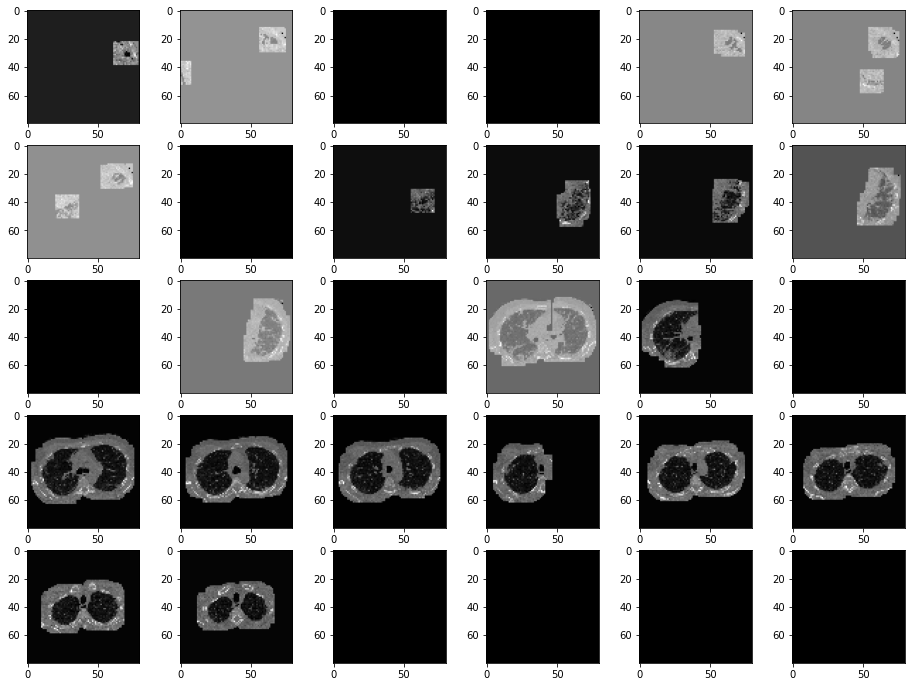

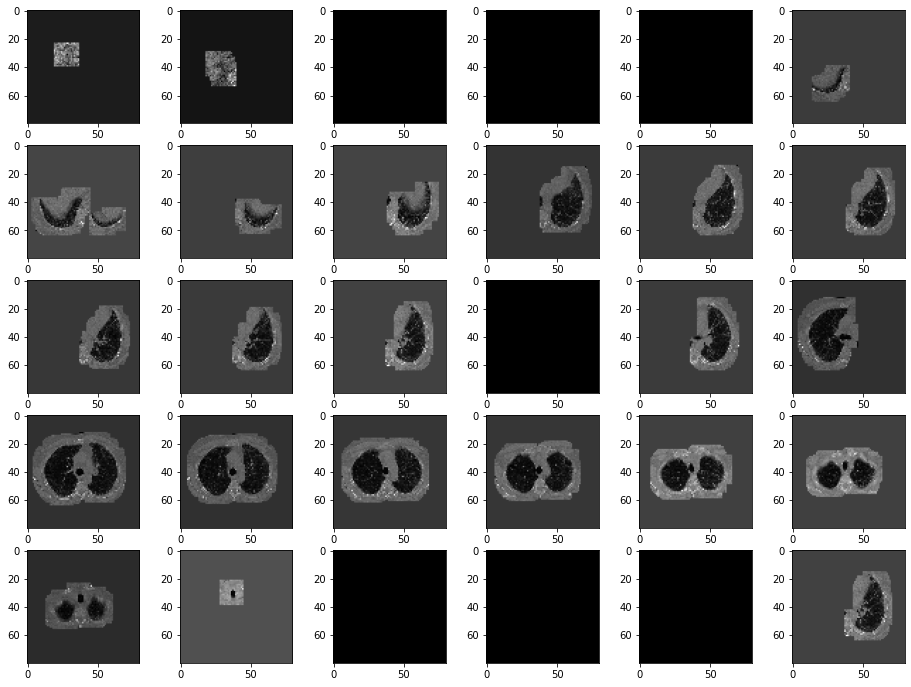

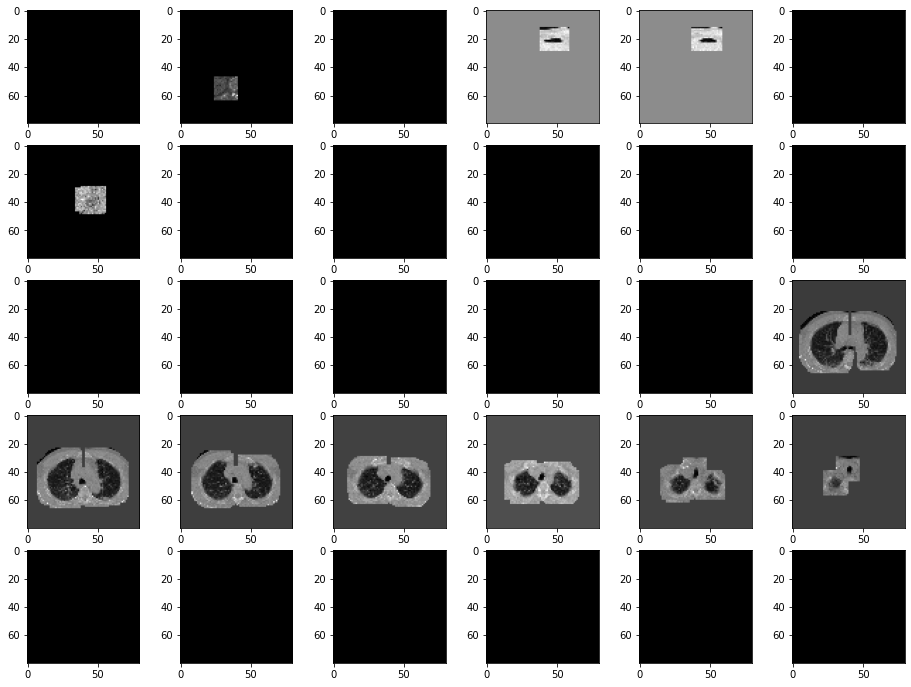

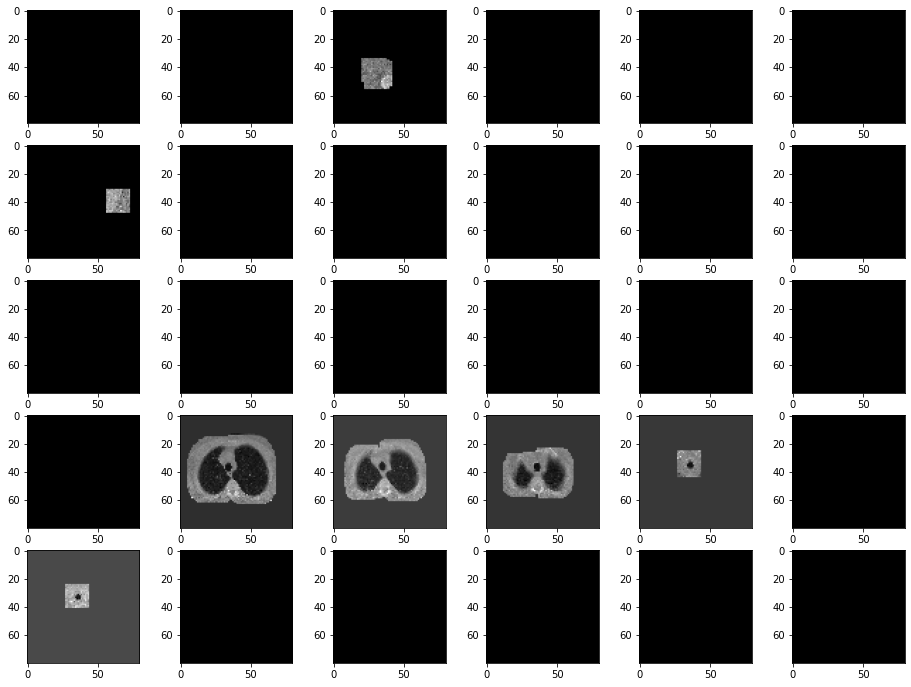

In [6]:
much_data = []
num_key_errors = 0
num_run_errors = 0
num_attribute_errors = 0

for num, patient in enumerate(patients[:5]):
    if num%100 == 0 and num != 0:
        print(num)
    
    """
    This is a work-around for files that require GDCM to read. Try implementing get_pixeldata() method.
    """      
    try:
        img_data, label, intercept = process_data(patient, 
                                                  labels_df, 
                                                  img_px_size=IMG_SIZE, 
                                                  num_slices=NUM_SLICES, 
                                                  visualize=True)
        
        much_data.append([img_data, label, intercept])
        
    except KeyError:
        print("Unlabeled data!") # error that Sentdex handled
        num_key_errors += 1
        
    except RuntimeError:
        print("GDCM required!") # error that requires GDCM dependency
        num_run_errors += 1
        
    except AttributeError:
        print("Missing ImagePositionPatient!") # use 
        num_attribute_errors += 1
        
np.save(SAVE_FILE, much_data, allow_pickle=True)
print("Save successful!")

if num_key_errors:
    print("KeyErrors: {}".format(num_key_errors))
if num_run_errors:
    print("Runtime Errors: {}".format(num_run_errors))
if num_attribute_errors:
    print("Attribute Errors: {}".format(num_attribute_errors))

-8.543078528986696
8.543078528986696


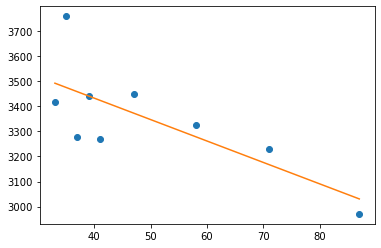

In [7]:
FVC = np.array(labels_df.at[patient, "FVC"])
Weeks = np.array(labels_df.at[patient, "Weeks"])
m, b = np.polyfit(Weeks, FVC, 1)
plt.plot(Weeks, FVC, 'o')
plt.plot(Weeks, m*Weeks + b)
print(m)
print(-m)

In [8]:
"""
Proof of Save/Load states:
"""
images = np.load(SAVE_FILE, allow_pickle=True)

In [9]:
# print("Raw Data: ", images[-1])

Normalized Image Data:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


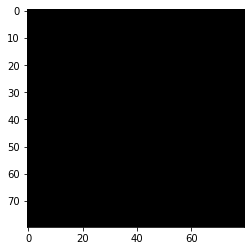

In [10]:
print("Normalized Image Data:\n", images[-1,0][1])
plt.figure()
plt.imshow(images[-1,0][10], cmap='gray')
plt.show()

### Proof of concept: Loading in training/validation data

In [ ]:
x_train = []
y_train = []
b = []
for n in range(len(images)):
    x_train.append(images[n, 0])
    y_train.append(images[n, 1])
    b.append(images[n, 2])
X = np.array(x_train)
Y = np.array(y_train)
print(X.shape)
print(Y.shape)
NUM_SLICES*IMG_SIZE**2

## Autoencoders And Lung Fibrosis Code
<https://www.kaggle.com/digvijayyadav/autoencoders-and-lung-fibrosis/notebook>

In [ ]:
def load_scan(path):
    """
    Loads scans from a folder and into a list.
    
    Parameters: path (Folder path)
    
    Returns: slices (List of slices)
    """
    
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices


def get_pixels_hu(scans):
    """
    Converts raw images to Hounsfield Units (HU).
    
    Parameters: scans (Raw images)
    
    Returns: image (NumPy array)
    """
    
    image = np.stack([s.pixel_array for s in scans])
    image = image.astype(np.int16)

    # Since the scanning equipment is cylindrical in nature and image output is square,
    # we set the out-of-scan pixels to 0
    image[image == -2000] = 0
    
    
    # HU = m*P + b
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)


test_patient_scans = load_scan(DATA_DIR + patients[2])
test_patient_images = get_pixels_hu(test_patient_scans)

#We'll be taking a random slice to perform segmentation:

for imgs in range(len(test_patient_images[0:5])):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,15))
    ax1.imshow(test_patient_images[imgs], cmap='gray')
    ax1.set_title("Original Slice")
    
    ax2.imshow(test_patient_images[imgs], cmap='gray')
    ax2.set_title("Original Slice")
    
    ax3.imshow(test_patient_images[imgs], cmap='gray')
    ax3.set_title("Original Slice")
    plt.show()

In [ ]:
def generate_markers(image):
    """
    Generates markers for a given image.
    
    Parameters: image
    
    Returns: Internal Marker, External Marker, Watershed Marker
    """
    
    #Creation of the internal Marker
    marker_internal = image < -400
    marker_internal = segmentation.clear_border(marker_internal)
    marker_internal_labels = measure.label(marker_internal)
    
    areas = [r.area for r in measure.regionprops(marker_internal_labels)]
    areas.sort()
    
    if len(areas) > 2:
        for region in measure.regionprops(marker_internal_labels):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       marker_internal_labels[coordinates[0], coordinates[1]] = 0
    
    marker_internal = marker_internal_labels > 0
    
    # Creation of the External Marker
    external_a = ndimage.binary_dilation(marker_internal, iterations=10)
    external_b = ndimage.binary_dilation(marker_internal, iterations=55)
    marker_external = external_b ^ external_a
    
    # Creation of the Watershed Marker
    marker_watershed = np.zeros((512, 512), dtype=np.int)
    marker_watershed += marker_internal * 255
    marker_watershed += marker_external * 128
    
    return marker_internal, marker_external, marker_watershed

test_patient_internal, test_patient_external, test_patient_watershed = generate_markers(test_patient_images[15])

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,15))

ax1.imshow(test_patient_internal, cmap='gray')
ax1.set_title("Internal Marker")
ax1.axis('off')

ax2.imshow(test_patient_external, cmap='gray')
ax2.set_title("External Marker")
ax2.axis('off')

ax3.imshow(test_patient_watershed, cmap='gray')
ax3.set_title("Watershed Marker")
ax3.axis('off')

plt.show()

In [ ]:
sample_image = pydicom.dcmread(train_image_files[7])
img = sample_image.pixel_array

plt.imshow(img, cmap='gray')
plt.title('Original Image')

In [ ]:
img = (img + sample_image.RescaleIntercept) / sample_image.RescaleSlope
img = img < -400 #HU unit range for lungs CT SCAN

plt.imshow(img, cmap='gray')
plt.title('Binary Mask Image')

In [ ]:
img = clear_border(img)
plt.imshow(img, cmap='gray')
plt.title('Cleaned Border Image')

In [ ]:
sample_image = pydicom.dcmread(train_image_files[5])
img = sample_image.pixel_array
img = label(img)
plt.imshow(img, cmap='gray')

In [ ]:
areas = [r.area for r in regionprops(img)]
areas.sort()
if len(areas) > 2:
    for region in regionprops(img):
        if region.area < areas[-2]:
            for coordinates in region.coords:                
                img[coordinates[0], coordinates[1]] = 0
img = img > 0
plt.imshow(img, cmap='gray')

In [ ]:

sample_image = pydicom.dcmread(train_image_files[5])
img = sample_image.pixel_array

mask_img = make_lungmask(img, display=True)